In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install requests beautifulsoup4 pandas
!pip install selenium
!apt-get update
!apt-get install -y chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_absolute_error
from scipy import stats

In [ ]:
path_of_file = "/content/drive/MyDrive/E_Commerce_Data_Analysis/data.csv"

try:
    data = pd.read_csv(path_of_file, encoding="latin1")
    print("Dataset loaded successfully! Here are the first 5 rows:")
    print(data.head())

except FileNotFoundError:
    print(f"Error: The file at '{path_of_file}' was not found.")
except pd.errors.EmptyDataError:
    print(f"Error: The file at '{path_of_file}' is empty.")
except UnicodeDecodeError:
    print(f"Error: Unable to decode the file.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Dataset loaded successfully! Here are the first 5 rows:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  


# Data Preprocessing

In [ ]:
# data information
print("\nDataset Info:")
data.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
# summary statistics of numeric columns
print("Summary Statistics for Numeric Columns:")
print(data.describe())

Summary Statistics for Numeric Columns:
            Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000


In [ ]:
# checking missing values
print("\nMissing Values:")
print(data.isnull().sum())


Missing Values:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [ ]:
# Drop columns that have excessive missing values (at threshold 50%)
missing_threshold = 0.5
data = data.loc[:, data.isnull().mean() < missing_threshold]
print("\nColumns with excessive missing values dropped.")

numeric_cols = data.select_dtypes(include=["number"]).columns
categorical_cols = data.select_dtypes(include=["object"]).columns

for col in numeric_cols:
        data[col].fillna(data[col].median(), inplace=True)

for col in categorical_cols:
        data[col].fillna("Unknown", inplace=True)

print("\nMissing Values After Handling:")
print(data.isnull().sum())


Columns with excessive missing values dropped.


<ipython-input-8-e2e3f5729618>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].median(), inplace=True)
<ipython-input-8-e2e3f5729618>:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us


Missing Values After Handling:
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


In [ ]:
# shape of the DataFrame before and after removing duplicates
print("Shape Before Duplicates Removing :", data.shape)

data = data.drop_duplicates()

print("Shape After Duplicates Removing:", data.shape)

Shape Before Duplicates Removing : (541909, 8)
Shape After Duplicates Removing: (536641, 8)


# Outlier Detection and Handling

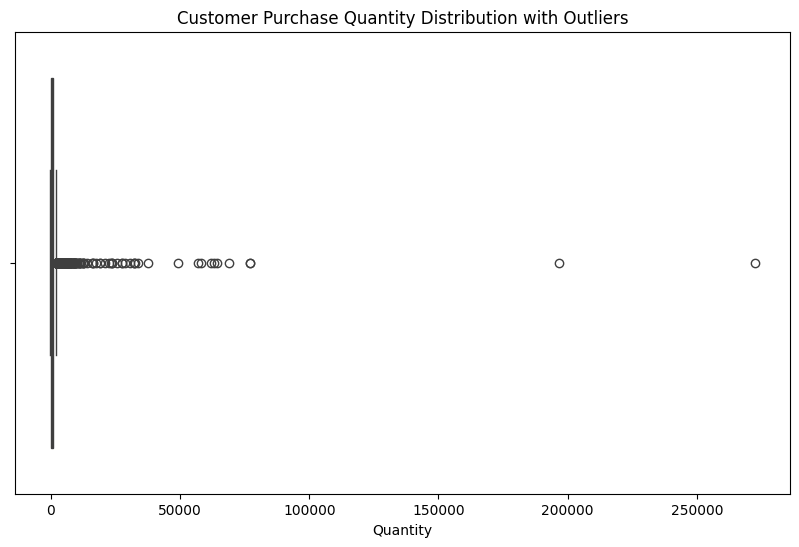

Outliers in customer purchase behavior: CustomerID
12347.0    2458
12348.0    2341
12357.0    2708
12362.0    2212
12370.0    2352
           ... 
18223.0    2890
18225.0    3204
18226.0    3459
18229.0    2488
18251.0    7824
Name: Quantity, Length: 409, dtype: int64


In [ ]:
# Customer Purchase Behavior
customer_purchase = data.groupby('CustomerID')['Quantity'].sum()

# Used IQR (Interquartile Range) method
Q1 = customer_purchase.quantile(0.25)
Q3 = customer_purchase.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_customer_purchase = customer_purchase[(customer_purchase < lower_bound) | (customer_purchase > upper_bound)]

plt.figure(figsize=(10, 6))
sns.boxplot(x=customer_purchase)
plt.title('Customer Purchase Quantity Distribution with Outliers')
plt.show()

print("Outliers in customer purchase behavior:", outliers_customer_purchase)

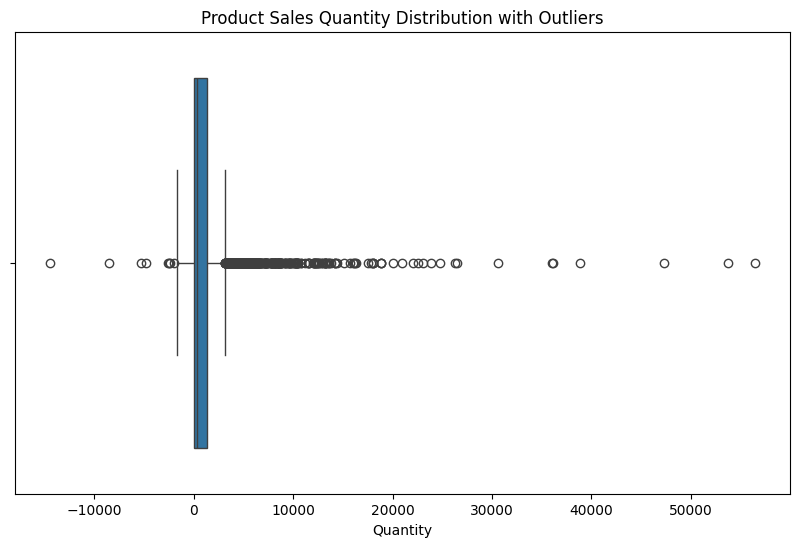

Outliers in product performance: StockCode
15036     22552
16014     13328
17003     23017
20668     12883
20719     13180
          ...  
84992     13189
85099B    47260
85099C    13619
85099F    15999
85123A    38811
Name: Quantity, Length: 72, dtype: int64


In [ ]:
# Detecting outliers in the quantity purchased per product.
product_sales = data.groupby('StockCode')['Quantity'].sum()

# Using Z-score
z_scores = np.abs(stats.zscore(product_sales))
outliers_product_sales = product_sales[z_scores > 3]

plt.figure(figsize=(10, 6))
sns.boxplot(x=product_sales)
plt.title('Product Sales Quantity Distribution with Outliers')
plt.show()

print("Outliers in product performance:", outliers_product_sales)

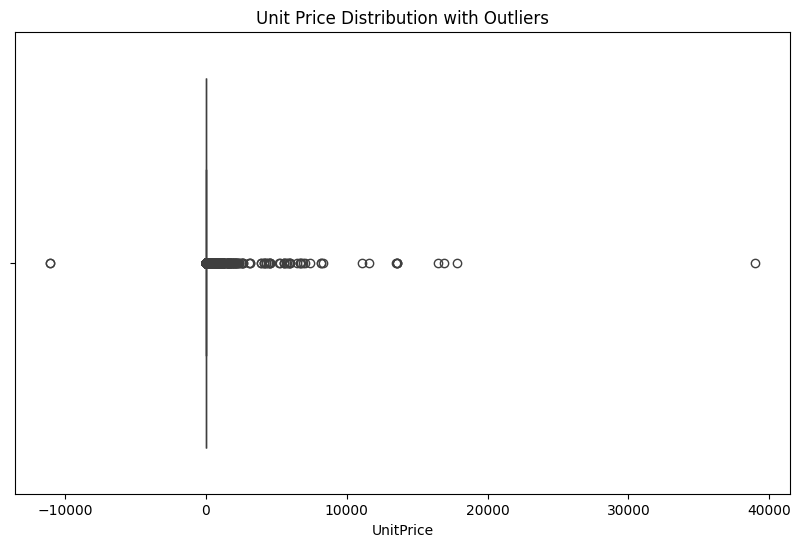

Outliers in pricing:        StockCode  UnitPrice
16         22622       9.95
45          POST      18.00
65         21258      10.95
141            D      27.50
151        22839      14.95
...          ...        ...
541768      POST      18.00
541786     22622      11.95
541831     22941       8.50
541849     22894       9.95
541892     21217       8.95

[39450 rows x 2 columns]


In [ ]:
# Detecting unusually high or low prices.
Q1_price = data['UnitPrice'].quantile(0.25)
Q3_price = data['UnitPrice'].quantile(0.75)
IQR_price = Q3_price - Q1_price
lower_bound_price = Q1_price - 1.5 * IQR_price
upper_bound_price = Q3_price + 1.5 * IQR_price

outliers_price = data[(data['UnitPrice'] < lower_bound_price) | (data['UnitPrice'] > upper_bound_price)]

plt.figure(figsize=(10, 6))
sns.boxplot(x=data['UnitPrice'])
plt.title('Unit Price Distribution with Outliers')
plt.show()

print("Outliers in pricing:", outliers_price[['StockCode', 'UnitPrice']])

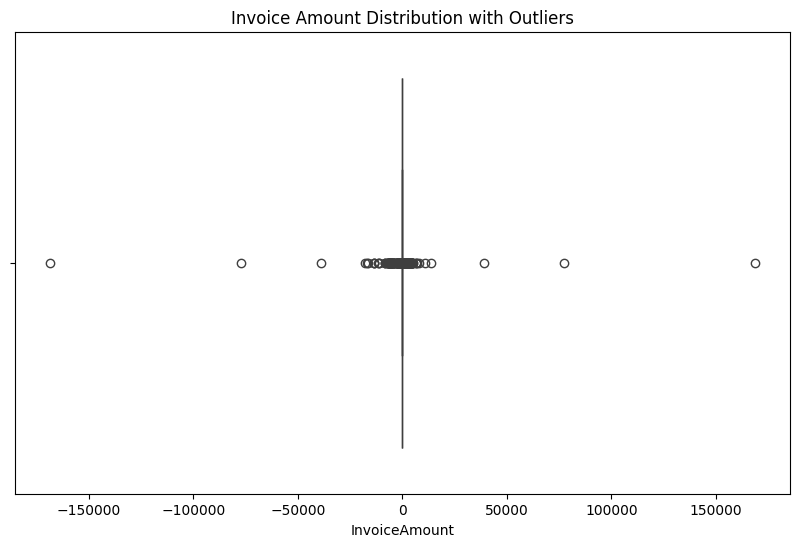

Duplicate Invoices:        InvoiceNo  CustomerID
0         536365     17850.0
1         536365     17850.0
2         536365     17850.0
3         536365     17850.0
4         536365     17850.0
...          ...         ...
541904    581587     12680.0
541905    581587     12680.0
541906    581587     12680.0
541907    581587     12680.0
541908    581587     12680.0

[530794 rows x 2 columns]
Outliers in invoice amounts:        InvoiceNo  InvoiceAmount
9         536367          54.08
26        536370          90.00
27        536370          90.00
28        536370          45.00
31        536370          40.80
...          ...            ...
541866    581583          66.60
541867    581584          51.84
541868    581584          88.80
541892    581586         214.80
541893    581586          70.80

[45626 rows x 2 columns]


In [ ]:
# Detecting duplicate invoices or invoices with high amounts.
duplicates = data[data.duplicated(subset=['InvoiceNo'], keep=False)]

data['InvoiceAmount'] = data['Quantity'] * data['UnitPrice']
Q1_invoice = data['InvoiceAmount'].quantile(0.25)
Q3_invoice = data['InvoiceAmount'].quantile(0.75)
IQR_invoice = Q3_invoice - Q1_invoice
lower_bound_invoice = Q1_invoice - 1.5 * IQR_invoice
upper_bound_invoice = Q3_invoice + 1.5 * IQR_invoice

outliers_invoice = data[(data['InvoiceAmount'] < lower_bound_invoice) | (data['InvoiceAmount'] > upper_bound_invoice)]

plt.figure(figsize=(10, 6))
sns.boxplot(x=data['InvoiceAmount'])
plt.title('Invoice Amount Distribution with Outliers')
plt.show()

print("Duplicate Invoices:", duplicates[['InvoiceNo', 'CustomerID']])
print("Outliers in invoice amounts:", outliers_invoice[['InvoiceNo', 'InvoiceAmount']])

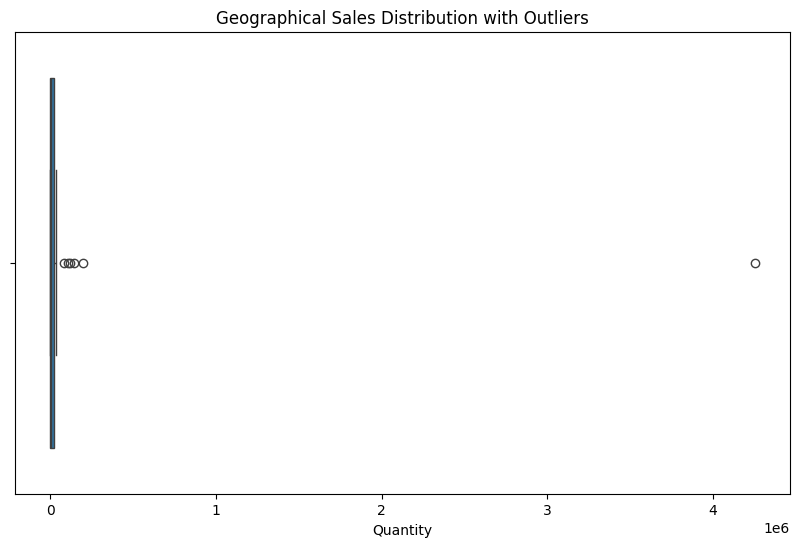

Outliers in geographical sales: Country
United Kingdom    4250328
Name: Quantity, dtype: int64


In [ ]:
# Identifying unusual geographic behavior in terms of purchase quantity.
country_sales = data.groupby('Country')['Quantity'].sum()

# Using Z-score
z_scores_country = np.abs(stats.zscore(country_sales))
outliers_country_sales = country_sales[z_scores_country > 3]

plt.figure(figsize=(10, 6))
sns.boxplot(x=country_sales)
plt.title('Geographical Sales Distribution with Outliers')
plt.show()

print("Outliers in geographical sales:", outliers_country_sales)

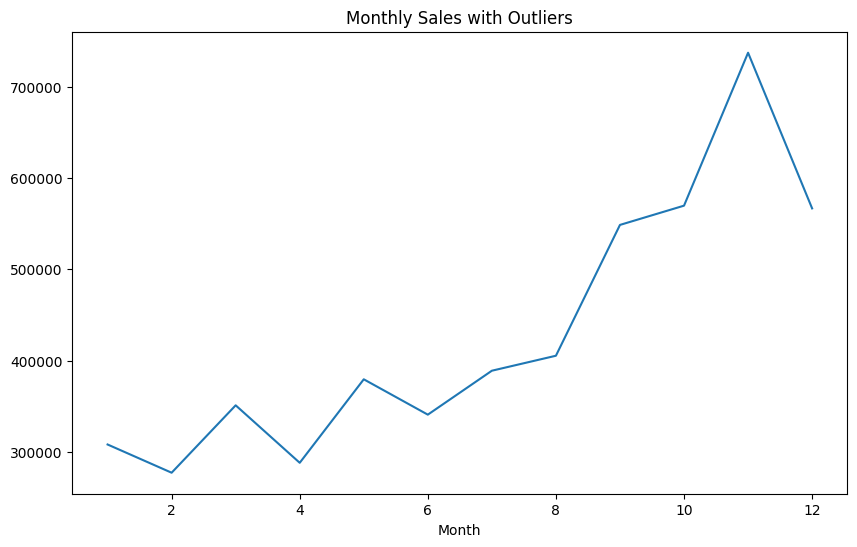

Outliers in seasonal behavior: Series([], Name: Quantity, dtype: int64)


In [ ]:
# Detecting unusual spikes in sales based on Invoice Date.
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

data['DayOfWeek'] = data['InvoiceDate'].dt.dayofweek
data['Month'] = data['InvoiceDate'].dt.month

monthly_sales = data.groupby('Month')['Quantity'].sum()

z_scores_monthly = np.abs(stats.zscore(monthly_sales))
outliers_monthly_sales = monthly_sales[z_scores_monthly > 3]

plt.figure(figsize=(10, 6))
sns.lineplot(x=monthly_sales.index, y=monthly_sales.values)
plt.title('Monthly Sales with Outliers')
plt.show()

print("Outliers in seasonal behavior:", outliers_monthly_sales)

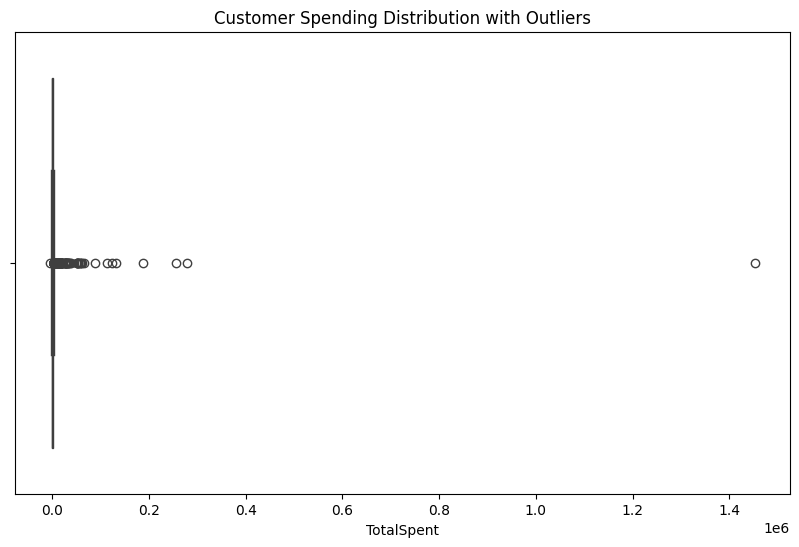

Outliers in customer value: CustomerID
12347.0    4310.00
12357.0    6207.67
12359.0    6182.98
12362.0    5154.58
12378.0    4008.62
            ...   
18223.0    6315.23
18225.0    5356.86
18226.0    5192.10
18229.0    7276.90
18251.0    4314.72
Name: TotalSpent, Length: 421, dtype: float64


In [ ]:
# Identifying high-value or inactive customers.
data['TotalSpent'] = data['Quantity'] * data['UnitPrice']
customer_value = data.groupby('CustomerID')['TotalSpent'].sum()

Q1_customer = customer_value.quantile(0.25)
Q3_customer = customer_value.quantile(0.75)
IQR_customer = Q3_customer - Q1_customer
lower_bound_customer = Q1_customer - 1.5 * IQR_customer
upper_bound_customer = Q3_customer + 1.5 * IQR_customer

outliers_customer_value = customer_value[(customer_value < lower_bound_customer) | (customer_value > upper_bound_customer)]

plt.figure(figsize=(10, 6))
sns.boxplot(x=customer_value)
plt.title('Customer Spending Distribution with Outliers')
plt.show()

print("Outliers in customer value:", outliers_customer_value)

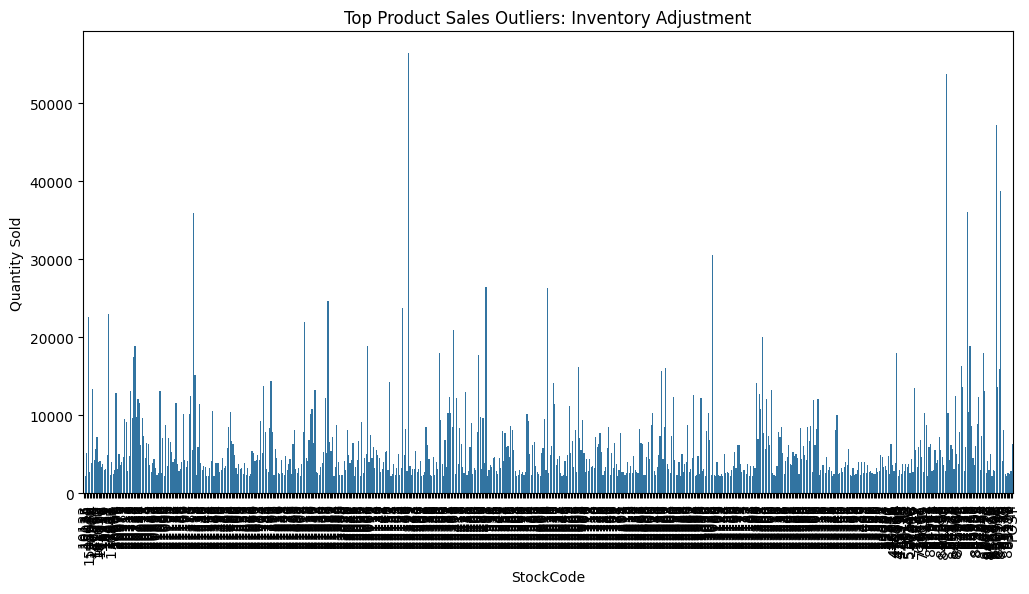

Top products with outlier sales quantities: StockCode
10133       2764
10135       2228
15034       5206
15036      22552
15056BL     2714
           ...  
85178       2229
85199S      2636
85212       2451
M           2924
POST        6353
Name: Quantity, Length: 636, dtype: int64


In [ ]:
# Inventory Adjustmentss
top_outliers_product_sales = product_sales[product_sales > upper_bound]

plt.figure(figsize=(12, 6))
sns.barplot(x=top_outliers_product_sales.index, y=top_outliers_product_sales.values)
plt.xticks(rotation=90)
plt.title('Top Product Sales Outliers: Inventory Adjustment')
plt.xlabel('StockCode')
plt.ylabel('Quantity Sold')
plt.show()

print("Top products with outlier sales quantities:", top_outliers_product_sales)

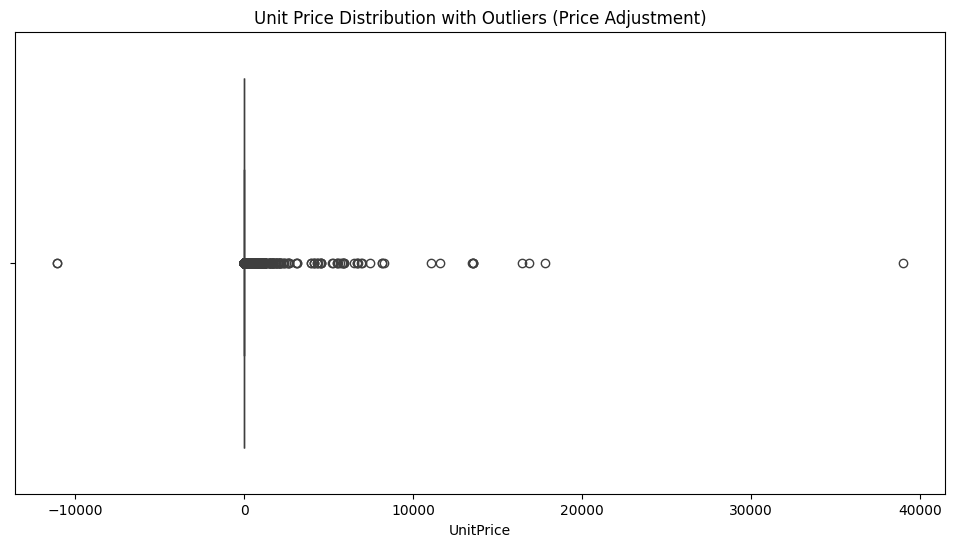

<ipython-input-21-b1975ea6e706>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_price['Price Adjustment'] = 'Outlier'


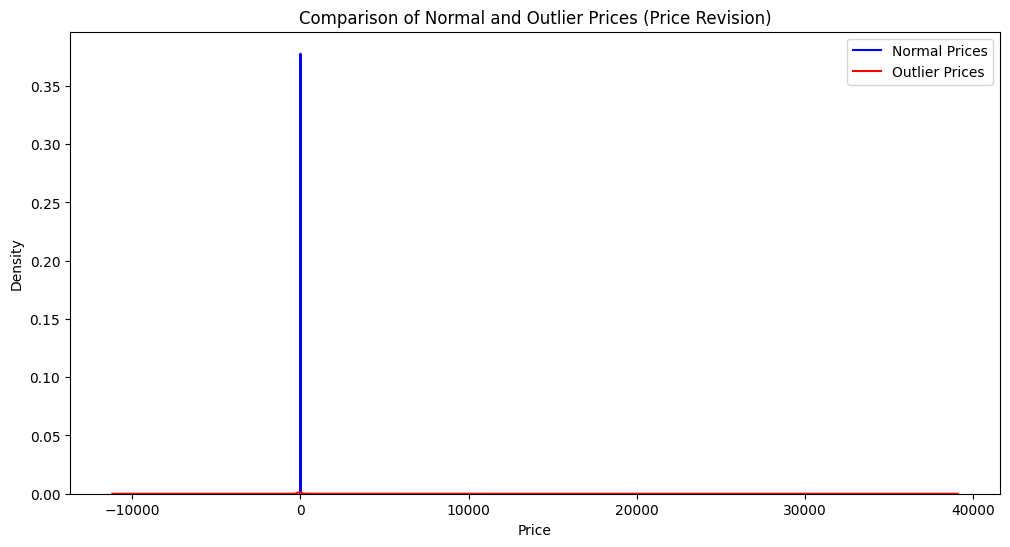

Outliers in pricing:        StockCode  UnitPrice
16         22622       9.95
45          POST      18.00
65         21258      10.95
141            D      27.50
151        22839      14.95
...          ...        ...
541768      POST      18.00
541786     22622      11.95
541831     22941       8.50
541849     22894       9.95
541892     21217       8.95

[39450 rows x 2 columns]


In [ ]:
# Revising Pricing for Outliers
plt.figure(figsize=(12, 6))
sns.boxplot(x=data['UnitPrice'])
plt.title('Unit Price Distribution with Outliers (Price Adjustment)')
plt.show()

outliers_price['Price Adjustment'] = 'Outlier'
normal_prices = data[~data['UnitPrice'].isin(outliers_price['UnitPrice'])]

plt.figure(figsize=(12, 6))
sns.kdeplot(normal_prices['UnitPrice'], label='Normal Prices', color='blue')
sns.kdeplot(outliers_price['UnitPrice'], label='Outlier Prices', color='red')
plt.title('Comparison of Normal and Outlier Prices (Price Revision)')
plt.xlabel('Price')
plt.ylabel('Density')
plt.legend()
plt.show()

print("Outliers in pricing:", outliers_price[['StockCode', 'UnitPrice']])

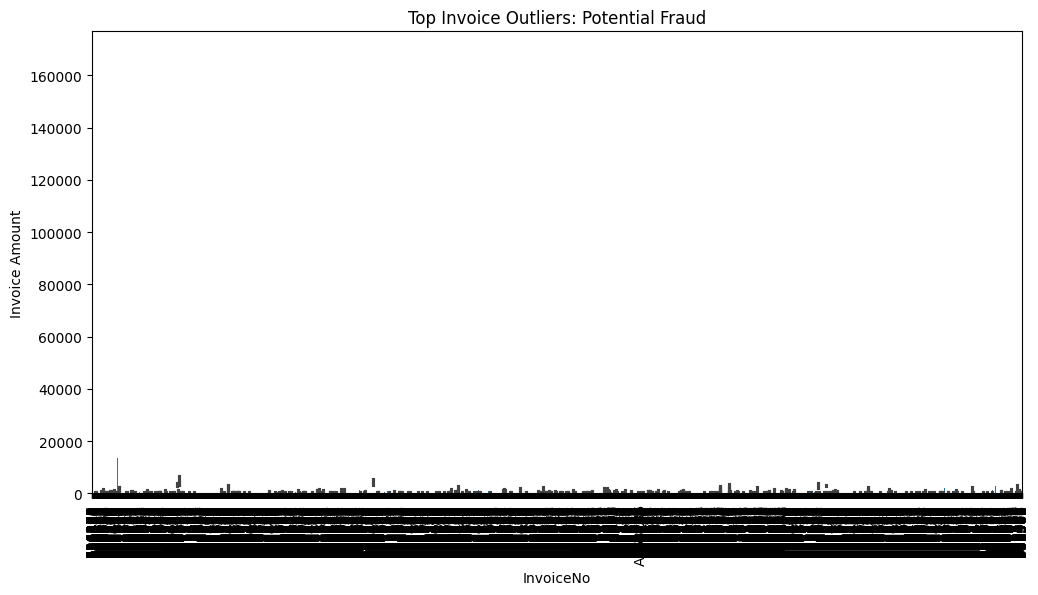

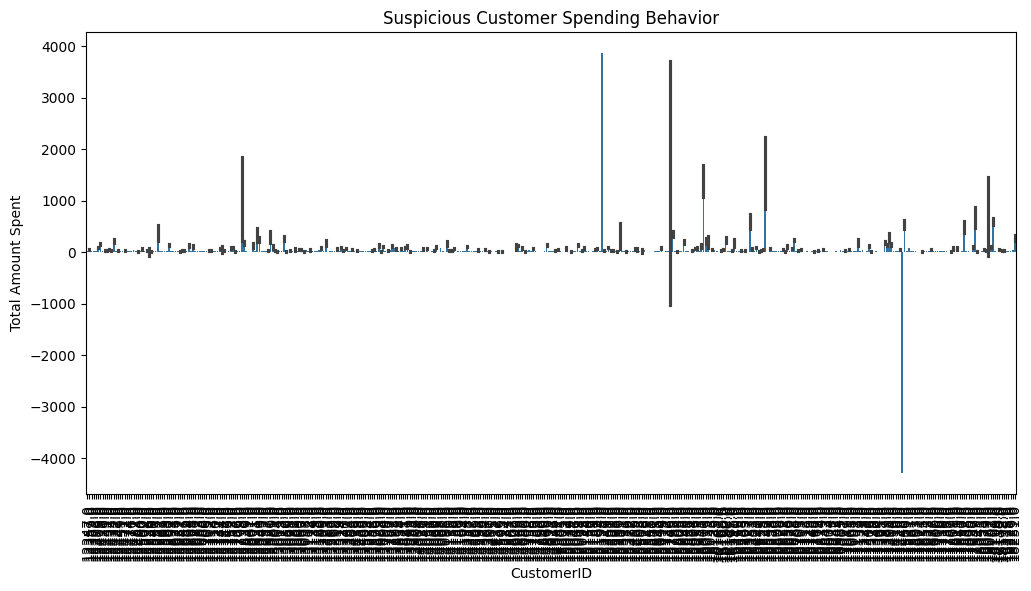

Outlier invoices potentially related to fraud:        InvoiceNo  InvoiceAmount
9         536367          54.08
26        536370          90.00
27        536370          90.00
28        536370          45.00
31        536370          40.80
...          ...            ...
541866    581583          66.60
541867    581584          51.84
541868    581584          88.80
541892    581586         214.80
541893    581586          70.80

[43083 rows x 2 columns]
Suspect customers based on outlier spending:         CustomerID  TotalSpent
0          17850.0       15.30
1          17850.0       20.34
2          17850.0       22.00
3          17850.0       20.34
4          17850.0       20.34
...            ...         ...
541889     15804.0       23.40
541890     13113.0       23.60
541891     13113.0       30.00
541892     13113.0      214.80
541893     13113.0       70.80

[295048 rows x 2 columns]


In [ ]:
# Investigating Potential Fraud
top_outliers_invoice = data[data['InvoiceAmount'] > upper_bound_invoice]

plt.figure(figsize=(12, 6))
sns.barplot(x=top_outliers_invoice['InvoiceNo'], y=top_outliers_invoice['InvoiceAmount'])
plt.xticks(rotation=90)
plt.title('Top Invoice Outliers: Potential Fraud')
plt.xlabel('InvoiceNo')
plt.ylabel('Invoice Amount')
plt.show()

suspect_customers = data[data['CustomerID'].isin(outliers_customer_value.index)]

plt.figure(figsize=(12, 6))
sns.barplot(x=suspect_customers['CustomerID'], y=suspect_customers['TotalSpent'])
plt.xticks(rotation=90)
plt.title('Suspicious Customer Spending Behavior')
plt.xlabel('CustomerID')
plt.ylabel('Total Amount Spent')
plt.show()

print("Outlier invoices potentially related to fraud:", top_outliers_invoice[['InvoiceNo', 'InvoiceAmount']])
print("Suspect customers based on outlier spending:", suspect_customers[['CustomerID', 'TotalSpent']])

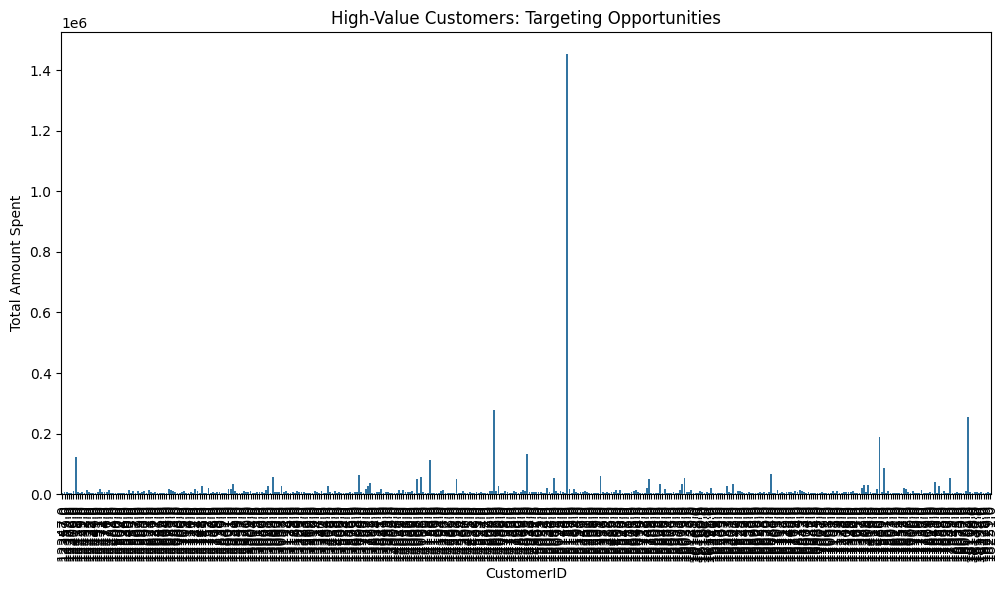

High-value customers: CustomerID
12347.0    4310.00
12357.0    6207.67
12359.0    6182.98
12362.0    5154.58
12378.0    4008.62
            ...   
18223.0    6315.23
18225.0    5356.86
18226.0    5192.10
18229.0    7276.90
18251.0    4314.72
Name: TotalSpent, Length: 420, dtype: float64


In [ ]:
# Customer Segmentation and High-Value Customer Targeting
high_value_customers = customer_value[customer_value > upper_bound_customer]

plt.figure(figsize=(12, 6))
sns.barplot(x=high_value_customers.index, y=high_value_customers.values)
plt.xticks(rotation=90)
plt.title('High-Value Customers: Targeting Opportunities')
plt.xlabel('CustomerID')
plt.ylabel('Total Amount Spent')
plt.show()

print("High-value customers:", high_value_customers)

# Products with Returns

Records with negative quantities (returns):
       InvoiceNo StockCode                       Description  Quantity  \
141      C536379         D                          Discount        -1   
154      C536383    35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235      C536391     22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236      C536391     21984  PACK OF 12 PINK PAISLEY TISSUES        -24   
237      C536391     21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   
...          ...       ...                               ...       ...   
540449   C581490     23144   ZINC T-LIGHT HOLDER STARS SMALL       -11   
541541   C581499         M                            Manual        -1   
541715   C581568     21258        VICTORIAN SEWING BOX LARGE        -5   
541716   C581569     84978  HANGING HEART JAR T-LIGHT HOLDER        -1   
541717   C581569     20979     36 PENCILS TUBE RED RETROSPOT        -5   

               InvoiceDate  UnitPrice  CustomerID         Country  

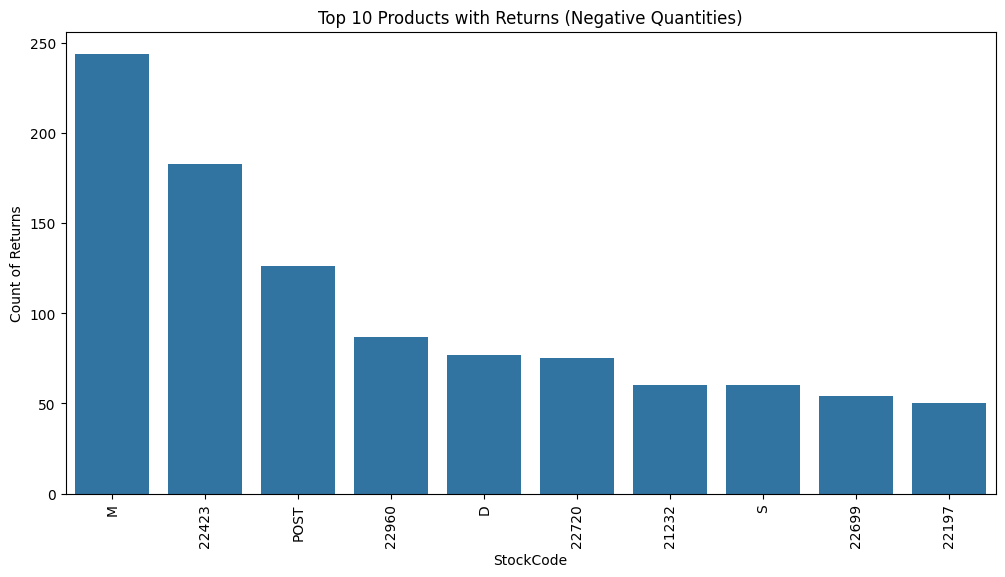

In [ ]:
# Negative quantities which represent product returns
negative_quantity_records = data[data['Quantity'] < 0]

print("Records with negative quantities (returns):")
print(negative_quantity_records)

plt.figure(figsize=(12, 6))
sns.barplot(
    x=negative_quantity_records['StockCode'].value_counts().index[:10],
    y=negative_quantity_records['StockCode'].value_counts().values[:10]
)
plt.title('Top 10 Products with Returns (Negative Quantities)')
plt.xlabel('StockCode')
plt.ylabel('Count of Returns')
plt.xticks(rotation=90)
plt.show()

# Overall Sales Insights

1. Top-Selling Products

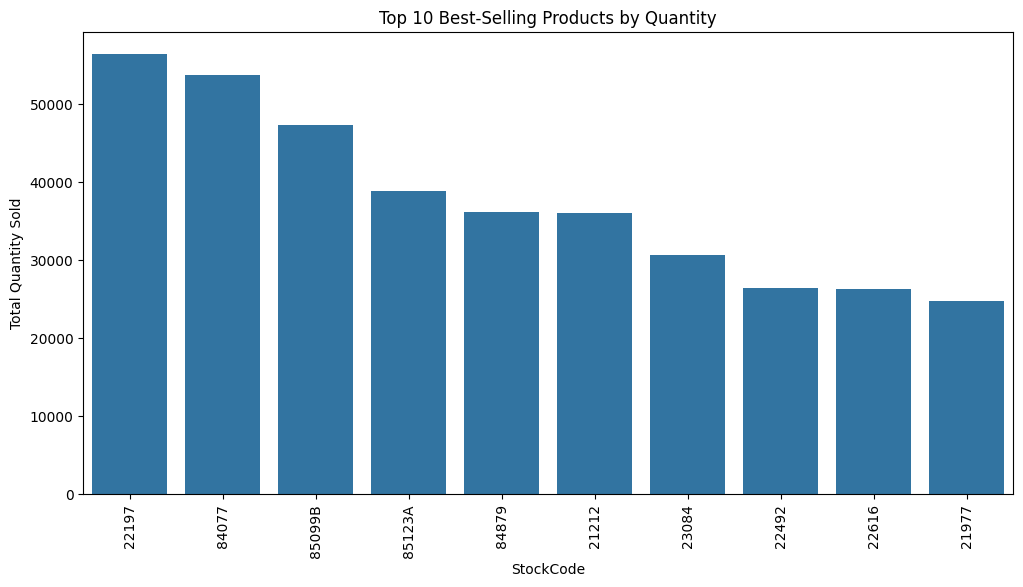

Top 10 best selling products :
 StockCode
22197     56427
84077     53751
85099B    47260
85123A    38811
84879     36122
21212     36016
23084     30597
22492     26437
22616     26299
21977     24719
Name: Quantity, dtype: int64


In [ ]:
top_selling_products = data.groupby('StockCode')['Quantity'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_selling_products.index, y=top_selling_products.values)
plt.title('Top 10 Best-Selling Products by Quantity')
plt.xlabel('StockCode')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=90)
plt.show()

print("Top 10 best selling products :\n", top_selling_products)

2. Revenue Contribution

In [ ]:
data['TotalAmount'] = data['Quantity'] * data['UnitPrice']

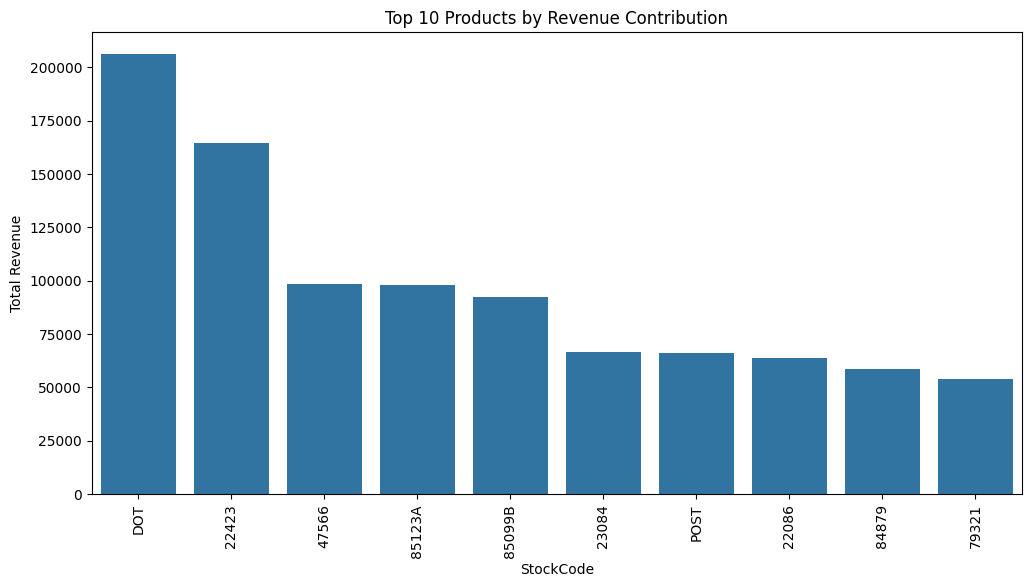

Top 10 products by revenue contribution:
 StockCode
DOT       206245.48
22423     164459.49
47566      98243.88
85123A     97838.45
85099B     92175.79
23084      66661.63
POST       66230.64
22086      63715.24
84879      58792.42
79321      53746.66
Name: TotalAmount, dtype: float64


In [ ]:
revenue_per_product = data.groupby('StockCode')['TotalAmount'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=revenue_per_product.index, y=revenue_per_product.values)
plt.title('Top 10 Products by Revenue Contribution')
plt.xlabel('StockCode')
plt.ylabel('Total Revenue')
plt.xticks(rotation=90)
plt.show()

print("Top 10 products by revenue contribution:\n", revenue_per_product)

# Customer Insights

1. Repeat Customers

Percentage of Repeat Customers: 69.97%
Percentage of One-Time Buyers: 30.03%


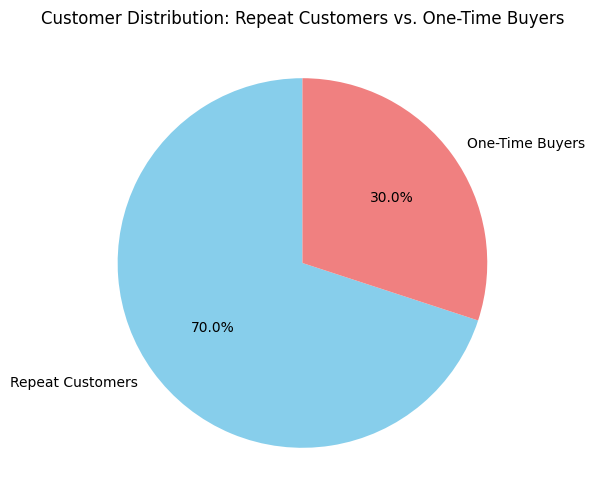

In [ ]:
customer_transactions = data.groupby('CustomerID')['InvoiceNo'].nunique()

repeat_customers = customer_transactions[customer_transactions > 1].count()
one_time_buyers = customer_transactions[customer_transactions == 1].count()

total_customers = customer_transactions.count()
repeat_percentage = (repeat_customers / total_customers) * 100
one_time_percentage = (one_time_buyers / total_customers) * 100

print(f"Percentage of Repeat Customers: {repeat_percentage:.2f}%")
print(f"Percentage of One-Time Buyers: {one_time_percentage:.2f}%")

plt.figure(figsize=(6, 6))
plt.pie(
    [repeat_percentage, one_time_percentage],
    labels=['Repeat Customers', 'One-Time Buyers'],
    autopct='%1.1f%%',
    colors=['skyblue', 'lightcoral'],
    startangle=90
)
plt.title('Customer Distribution: Repeat Customers vs. One-Time Buyers')
plt.show()

2. Country Analysis

Top 10 countries by total revenue:
                 Total Revenue  Transaction Count
Country                                         
United Kingdom    8167128.184              23494
Netherlands        284661.540                101
EIRE               262993.380                360
Germany            221509.470                603
France             197317.110                461
Australia          137009.770                 69
Switzerland         56363.050                 74
Spain               54756.030                105
Belgium             40910.960                119
Sweden              36585.410                 46


<ipython-input-29-77d4e1cf88fb>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


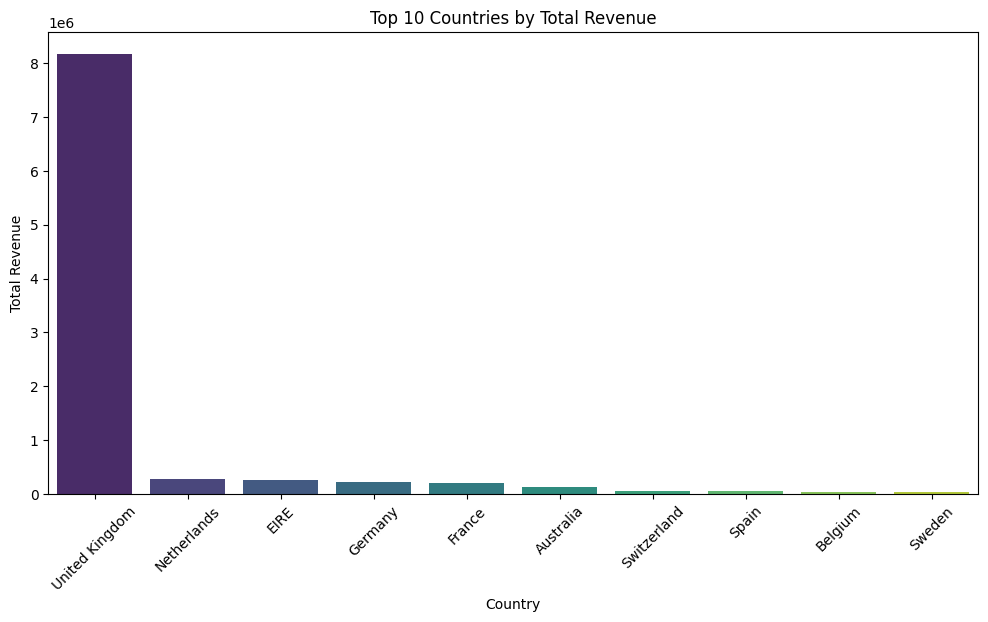

In [ ]:
# revenue and transaction count per country
country_analysis = data.groupby('Country').agg({
    'TotalAmount': 'sum',
    'InvoiceNo': 'nunique'
}).rename(columns={'TotalAmount': 'Total Revenue', 'InvoiceNo': 'Transaction Count'})

top_countries_by_revenue = country_analysis.sort_values('Total Revenue', ascending=False).head(10)
print("Top 10 countries by total revenue:\n", top_countries_by_revenue)

plt.figure(figsize=(12, 6))
sns.barplot(
    x=top_countries_by_revenue.index,
    y=top_countries_by_revenue['Total Revenue'],
    palette='viridis'
)
plt.title('Top 10 Countries by Total Revenue')
plt.xlabel('Country')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.show()

Top 10 countries by average revenue per customer:
              TotalAmount  CustomerID  Avg Revenue Per Customer
Country                                                       
EIRE           262993.38           4              65748.345000
Netherlands    284661.54           9              31629.060000
Australia      137009.77           9              15223.307778
Hong Kong        9908.24           1               9908.240000
Singapore        9120.39           1               9120.390000
Sweden          36585.41           8               4573.176250
Japan           35340.62           8               4417.577500
Iceland          4310.00           1               4310.000000
Norway          35163.46          10               3516.346000
Switzerland     56363.05          22               2561.956818


<ipython-input-30-13b909726026>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


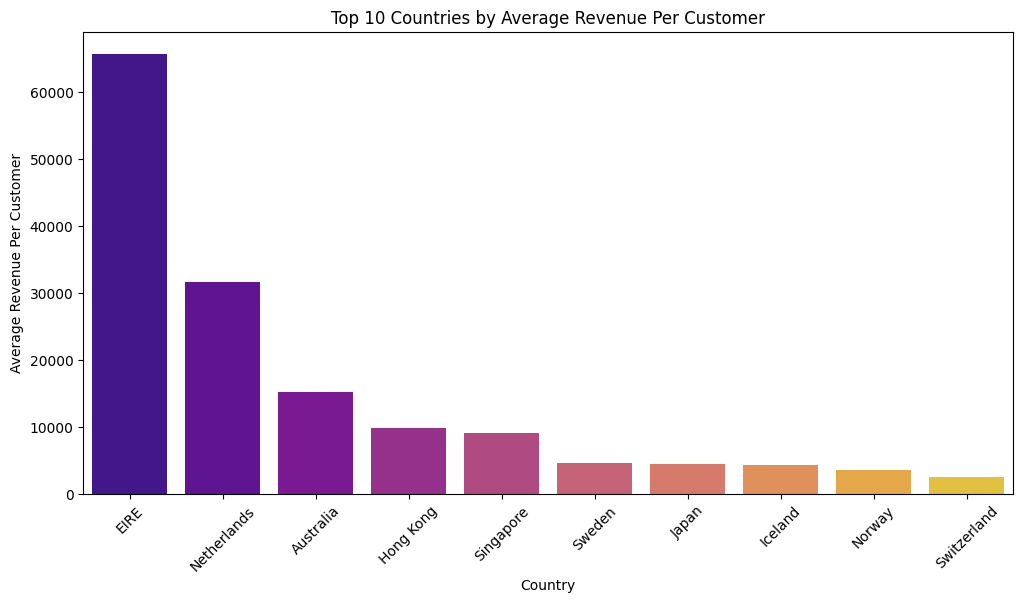

In [ ]:
# average revenue per customer by country
avg_revenue_per_customer = data.groupby('Country').agg({
    'TotalAmount': 'sum',
    'CustomerID': 'nunique'
})
avg_revenue_per_customer['Avg Revenue Per Customer'] = avg_revenue_per_customer['TotalAmount'] / avg_revenue_per_customer['CustomerID']

top_avg_revenue_countries = avg_revenue_per_customer.sort_values('Avg Revenue Per Customer', ascending=False).head(10)
print("Top 10 countries by average revenue per customer:\n", top_avg_revenue_countries)

plt.figure(figsize=(12, 6))
sns.barplot(
    x=top_avg_revenue_countries.index,
    y=top_avg_revenue_countries['Avg Revenue Per Customer'],
    palette='plasma'
)
plt.title('Top 10 Countries by Average Revenue Per Customer')
plt.xlabel('Country')
plt.ylabel('Average Revenue Per Customer')
plt.xticks(rotation=45)
plt.show()

# RFM Analysis

In [ ]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

reference_date = data['InvoiceDate'].max()

# RFM metrics
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                   # Frequency
    'TotalAmount': 'sum'                                      # Monetary
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalAmount': 'Monetary'
}).reset_index()

print("RFM Metrics (Top 5 Rows):")
print(rfm.head())

RFM Metrics (Top 5 Rows):
   CustomerID  Recency  Frequency  Monetary
0     12346.0      325          2      0.00
1     12347.0        1          7   4310.00
2     12348.0       74          4   1797.24
3     12349.0       18          1   1757.55
4     12350.0      309          1    334.40


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

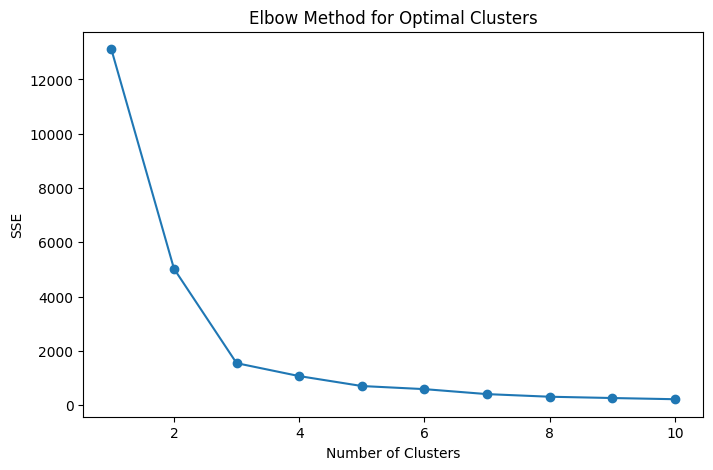

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

segment_map = {0: 'Low-Value', 1: 'Medium-Value', 2: 'High-Value', 3: 'Very High-Value'}
rfm['Segment'] = rfm['Cluster'].map(segment_map)

print("RFM Segmentation (Top 5 Rows):")
print(rfm.head())

RFM Segmentation (Top 5 Rows):
   CustomerID  Recency  Frequency  Monetary  Cluster     Segment
0     12346.0      325          2      0.00        2  High-Value
1     12347.0        1          7   4310.00        0   Low-Value
2     12348.0       74          4   1797.24        0   Low-Value
3     12349.0       18          1   1757.55        0   Low-Value
4     12350.0      309          1    334.40        2  High-Value


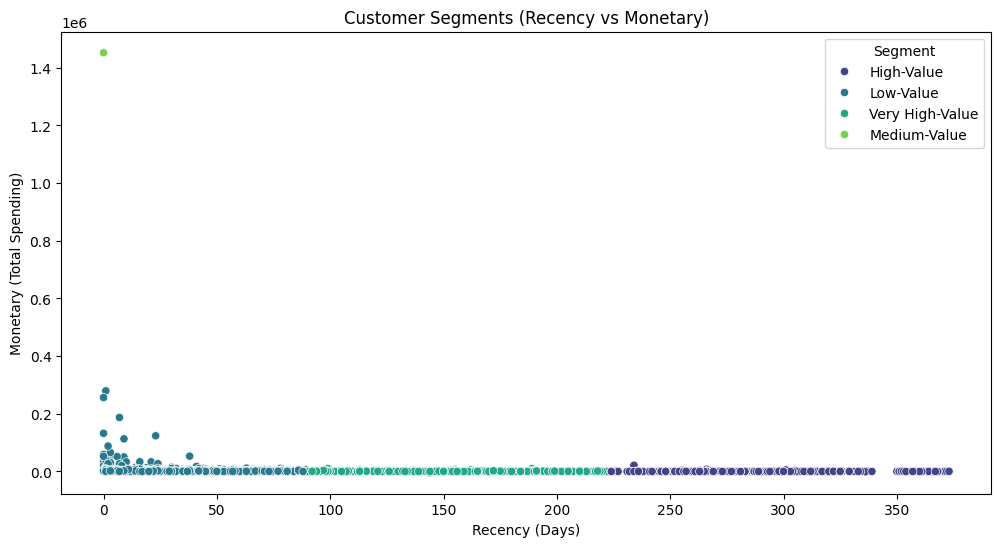

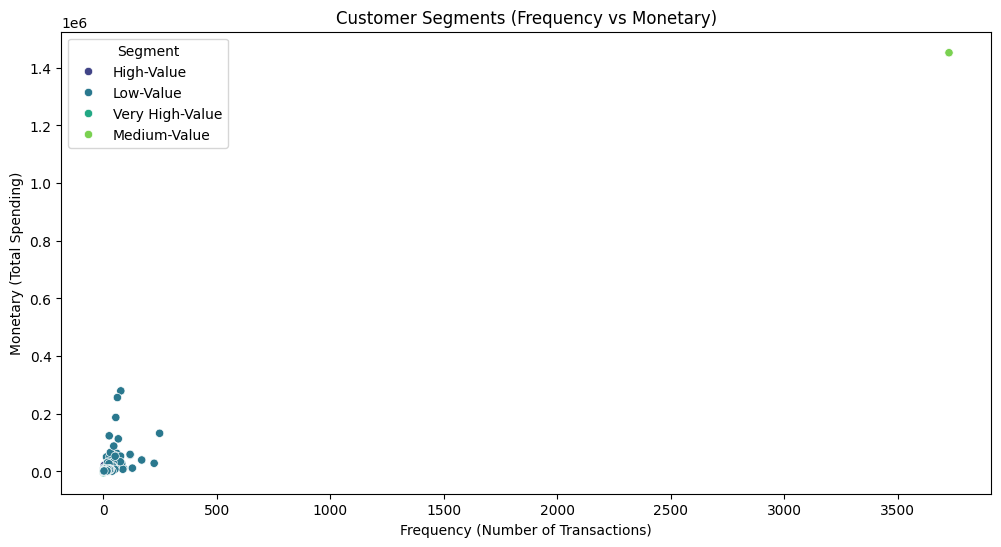

In [ ]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=rfm,
    x='Recency',
    y='Monetary',
    hue='Segment',
    palette='viridis'
)
plt.title('Customer Segments (Recency vs Monetary)')
plt.xlabel('Recency (Days)')
plt.ylabel('Monetary (Total Spending)')
plt.legend(title='Segment')
plt.show()

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=rfm,
    x='Frequency',
    y='Monetary',
    hue='Segment',
    palette='viridis'
)
plt.title('Customer Segments (Frequency vs Monetary)')
plt.xlabel('Frequency (Number of Transactions)')
plt.ylabel('Monetary (Total Spending)')
plt.legend(title='Segment')
plt.show()

# Profitability Analysis

In [ ]:
product_sales = data.groupby('Description').agg({
    'Quantity': 'sum',
    'UnitPrice': 'mean',
    'TotalAmount': 'sum'
}).reset_index()

product_sales = product_sales[product_sales['Quantity'] > 0]

product_sales['Profitability'] = product_sales['TotalAmount'] - (product_sales['UnitPrice'] * product_sales['Quantity'])

print("Top 5 Rows of Product Sales with Profitability:")
print(product_sales.head())

Top 5 Rows of Product Sales with Profitability:
                      Description  Quantity  UnitPrice  TotalAmount  \
0   4 PURPLE FLOCK DINNER CANDLES       142   2.450513       285.70   
1   50'S CHRISTMAS GIFT BAG LARGE      1913   1.425231      2341.13   
2               DOLLY GIRL BEAKER      2444   1.503539      2877.50   
3     I LOVE LONDON MINI BACKPACK       388   4.616667      1624.02   
4     I LOVE LONDON MINI RUCKSACK         1   4.150000         4.15   

   Profitability  
0     -62.272821  
1    -385.336462  
2    -797.150112  
3    -167.246667  
4       0.000000  


In [ ]:
# Sort products by profitability
most_profitable = product_sales.sort_values('Profitability', ascending=False).head(10)
least_profitable = product_sales.sort_values('Profitability', ascending=True).head(10)

print("Top 10 Most Profitable Products:")
print(most_profitable)

print("\nTop 10 Least Profitable Products:")
print(least_profitable)


Top 10 Most Profitable Products:
                              Description  Quantity  UnitPrice  TotalAmount  \
3015  ROTATING SILVER ANGELS T-LIGHT HLDR        85   3.402479     26103.98   
726             CHARLOTTE BAG SUKI DESIGN     17974   1.211153     29140.56   
1771    HOT WATER BOTTLE TEA AND SYMPATHY      5659   5.008374     32663.34   
3627               TEA TIME PARTY BUNTING      1154   6.123200      9233.47   
2871          RED RETROSPOT CHARLOTTE BAG     17544   1.135634     21603.08   
3935        WHITE SKULL HOT WATER BOTTLE       3731   4.966602     19946.27   
3668        TRADITIONAL NAUGHTS & CROSSES      2841   1.892137      6406.91   
3669     TRADITIONAL PICK UP STICKS GAME       2772   1.431119      4931.87   
3557             STRAWBERRY CHARLOTTE BAG      9718   1.195786     12485.44   
3996               WOODLAND CHARLOTTE BAG     13180   1.204153     16657.05   

      Profitability  
3015   25814.769316  
726     7371.296098  
1771    4320.950215  
3627    2

<ipython-input-40-2806b29c96e6>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


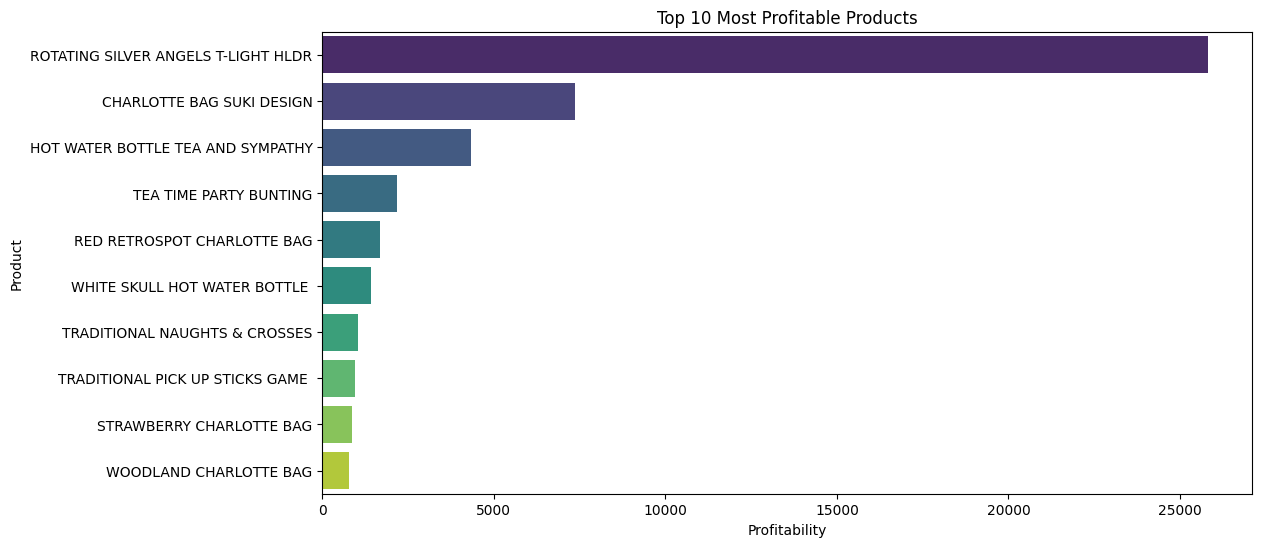

<ipython-input-40-2806b29c96e6>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


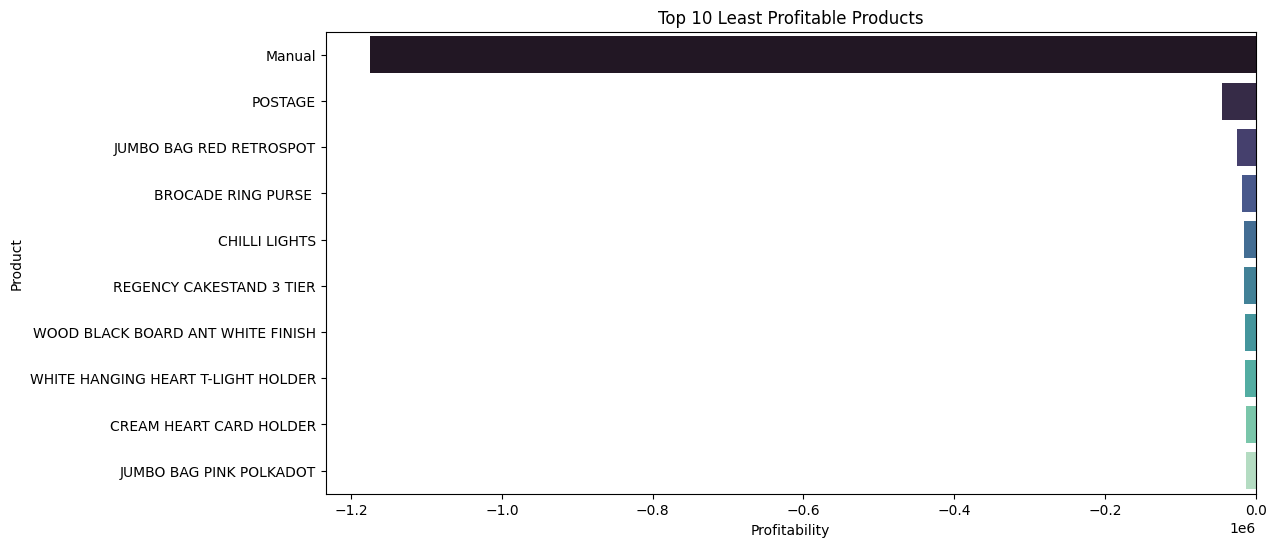

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(
    data=most_profitable,
    x='Profitability',
    y='Description',
    palette='viridis'
)
plt.title('Top 10 Most Profitable Products')
plt.xlabel('Profitability')
plt.ylabel('Product')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(
    data=least_profitable,
    x='Profitability',
    y='Description',
    palette='mako'
)
plt.title('Top 10 Least Profitable Products')
plt.xlabel('Profitability')
plt.ylabel('Product')
plt.show()

Top 10 Products with Highest Returns:
                              Description  Quantity  TotalAmount
1220          PAPER CRAFT , LITTLE BIRDIE    -80995   -168469.60
1056       MEDIUM CERAMIC TOP STORAGE JAR    -74494    -77479.64
1842                              Unknown    -46156         0.00
2064         printing smudges/thrown away    -19200         0.00
1843               Unsaleable, destroyed.    -15644         0.00
2025                                check    -13247         0.00
67                                      ?     -9496         0.00
1497  ROTATING SILVER ANGELS T-LIGHT HLDR     -9376      -321.60
1355         Printing smudges/thrown away     -9058         0.00
559                               Damaged     -7540         0.00


<ipython-input-41-3888f53a4940>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


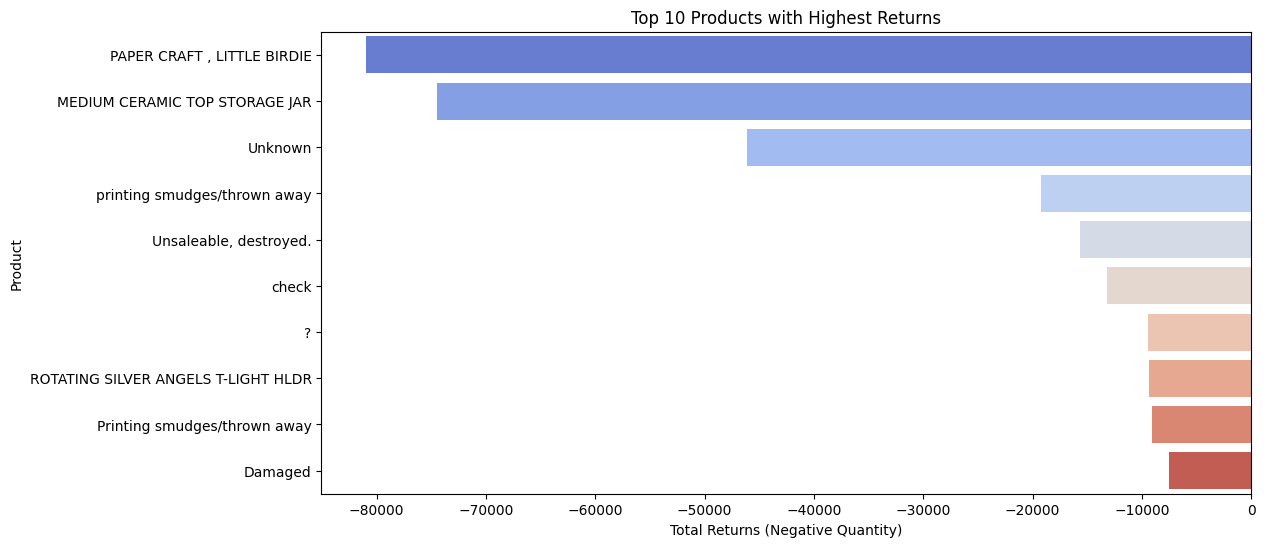

In [ ]:
returns = data[data['Quantity'] < 0].groupby('Description').agg({
    'Quantity': 'sum',         # Total returns
    'TotalAmount': 'sum'       # Revenue loss due to returns
}).reset_index()

top_returns = returns.sort_values('Quantity', ascending=True).head(10)

print("Top 10 Products with Highest Returns:")
print(top_returns)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_returns,
    x='Quantity',
    y='Description',
    palette='coolwarm'
)
plt.title('Top 10 Products with Highest Returns')
plt.xlabel('Total Returns (Negative Quantity)')
plt.ylabel('Product')
plt.show()

# Web Scraping Data

In [ ]:
import requests
from bs4 import BeautifulSoup

product_data = []

product_id_counter = 1

base_url = "http://books.toscrape.com/catalogue/page-{}.html"

page_number = 1
while True:

    url = base_url.format(page_number)

    response = requests.get(url)

    if response.status_code == 404:
        break

    soup = BeautifulSoup(response.text, "html.parser")

    products = soup.find_all("article", class_="product_pod")

    for product in products:
        title = product.find("h3").find("a")["title"]
        price = product.find("p", class_="price_color").text

        product_code = product.find("p", class_="instock availability")
        product_code = "N/A" if not product_code else product_code.text.strip()

        rating_class = product.find("p", class_="star-rating")
        rating = rating_class["class"][1] if rating_class else "N/A"

        product_info = {
            "product_id": product_id_counter,
            "title": title,
            "price": price,
            "rating": rating,
            "product_code": product_code
        }

        product_data.append(product_info)

        product_id_counter += 1

    page_number += 1

for product in product_data[:50]:
    print(f"Product ID: {product['product_id']}, Title: {product['title']}, Price: {product['price']}, Rating: {product['rating']}, Product Code: {product['product_code']}")

Product ID: 1, Title: A Light in the Attic, Price: Â£51.77, Rating: Three, Product Code: In stock
Product ID: 2, Title: Tipping the Velvet, Price: Â£53.74, Rating: One, Product Code: In stock
Product ID: 3, Title: Soumission, Price: Â£50.10, Rating: One, Product Code: In stock
Product ID: 4, Title: Sharp Objects, Price: Â£47.82, Rating: Four, Product Code: In stock
Product ID: 5, Title: Sapiens: A Brief History of Humankind, Price: Â£54.23, Rating: Five, Product Code: In stock
Product ID: 6, Title: The Requiem Red, Price: Â£22.65, Rating: One, Product Code: In stock
Product ID: 7, Title: The Dirty Little Secrets of Getting Your Dream Job, Price: Â£33.34, Rating: Four, Product Code: In stock
Product ID: 8, Title: The Coming Woman: A Novel Based on the Life of the Infamous Feminist, Victoria Woodhull, Price: Â£17.93, Rating: Three, Product Code: In stock
Product ID: 9, Title: The Boys in the Boat: Nine Americans and Their Epic Quest for Gold at the 1936 Berlin Olympics, Price: Â£22.60, R

## Data Preprocessing

Converting to dataframe

In [ ]:
df = pd.DataFrame(product_data)

Cleaning dataset

In [ ]:
df['price'] = df['price'].replace({'Â£': ''}, regex=True).astype(float)

Convert rating to numerical scale

In [ ]:
rating_map = {
    'One': 1,
    'Two': 2,
    'Three': 3,
    'Four': 4,
    'Five': 5
}
df['rating'] = df['rating'].map(rating_map)

Handle missing values

In [ ]:
df['product_code'] = df['product_code'].replace('N/A', np.nan)

Remove duplicates

In [ ]:
df.drop_duplicates(inplace=True)

normalizing the price column

In [ ]:
df['normalized_price'] = (df['price'] - df['price'].mean()) / df['price'].std()

In [ ]:
df.head()

,product_id,title,price,rating,product_code,normalized_price
0,1,A Light in the Attic,51.77,3,In stock,1.155950
1,2,Tipping the Velvet,53.74,1,In stock,1.292313
2,3,Soumission,50.10,1,In stock,1.040353
3,4,Sharp Objects,47.82,4,In stock,0.882531
4,5,Sapiens: A Brief History of Humankind,54.23,5,In stock,1.326231


## Analysis

Average Price by Rating

<ipython-input-78-d427ebbc8344>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="rating", y="price", data=df, palette="Set2")


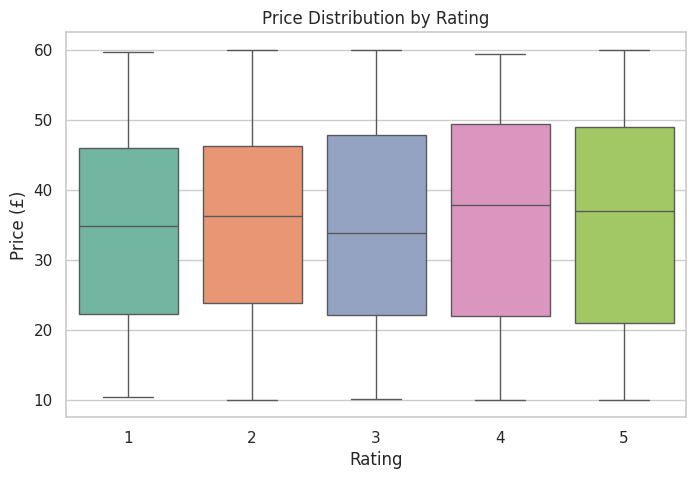

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 5))
sns.boxplot(x="rating", y="price", data=df, palette="Set2")
plt.title('Price Distribution by Rating')
plt.xlabel('Rating')
plt.ylabel('Price (£)')
plt.show()

Price Distribution

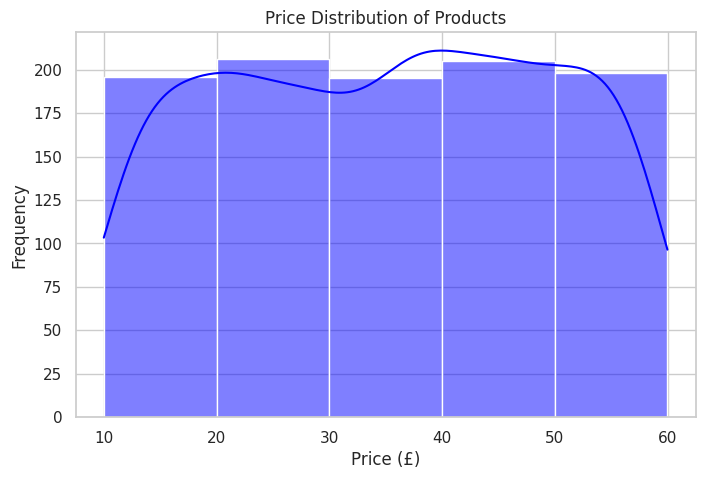

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(df['price'], kde=True, color='blue', bins=5)
plt.title('Price Distribution of Products')
plt.xlabel('Price (£)')
plt.ylabel('Frequency')
plt.show()

Rating Distribution

<ipython-input-80-b22820071190>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="rating", data=df, palette="Set1")


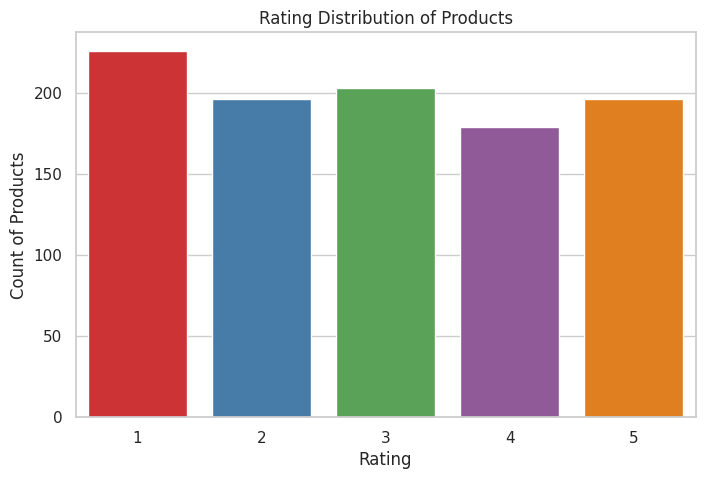

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(x="rating", data=df, palette="Set1")
plt.title('Rating Distribution of Products')
plt.xlabel('Rating')
plt.ylabel('Count of Products')
plt.show()

Correlation between Price and Rating

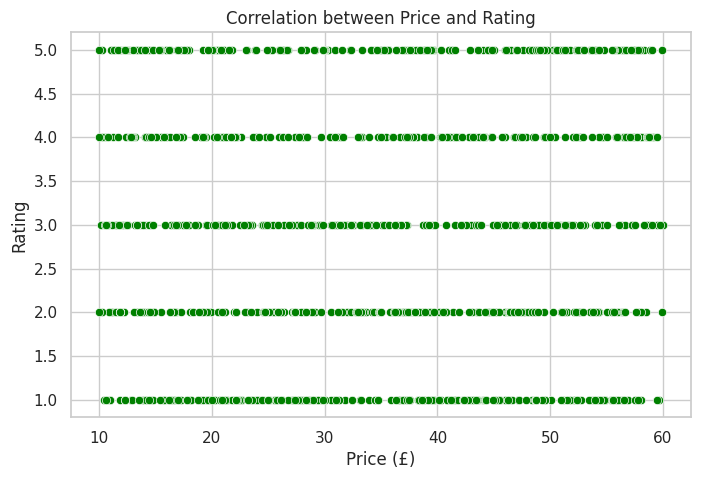

In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x="price", y="rating", data=df, color='green')
plt.title('Correlation between Price and Rating')
plt.xlabel('Price (£)')
plt.ylabel('Rating')
plt.show()

 top 10 rated products

<ipython-input-83-aa4a7a5b77ec>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="product_id", y="price", data=top_rated_products_sorted, palette="coolwarm")


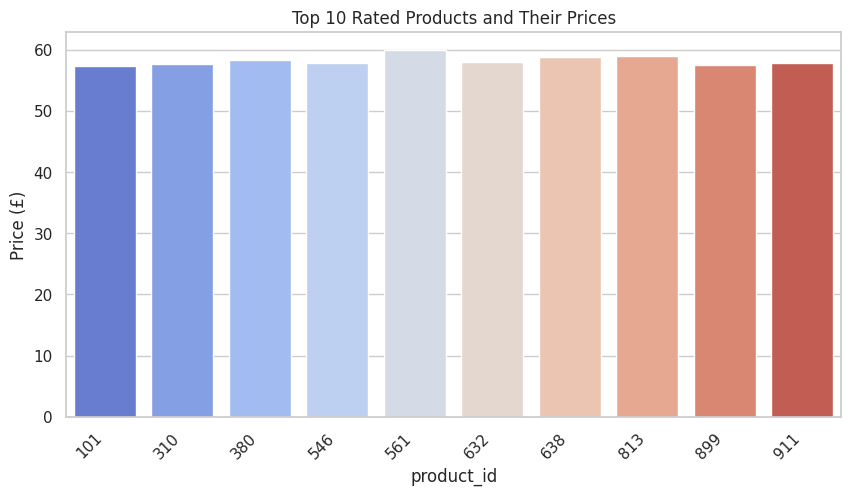

In [ ]:
top_rated_products = df[df['rating'] == 5]
top_rated_products_sorted = top_rated_products.sort_values(by="price", ascending=False).head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x="product_id", y="price", data=top_rated_products_sorted, palette="coolwarm")
plt.title('Top 10 Rated Products and Their Prices')
plt.xlabel('product_id')
plt.ylabel('Price (£)')
plt.xticks(rotation=45, ha="right")
plt.show()

products with lowest prices but high ratings

Top 10 Products with Lowest Price and High Ratings:
     product_id                                              title  price  \
638         639                         An Abundance of Katherines  10.00   
501         502                              The Origin of Species  10.01   
716         717  The Tipping Point: How Little Things Can Make ...  10.02   
84           85                                           Patience  10.16   
302         303                               Greek Mythic History  10.23   
558         559  The Fellowship of the Ring (The Lord of the Ri...  10.27   
479         480                                  History of Beauty  10.29   
242         243  The Lucifer Effect: Understanding How Good Peo...  10.40   
434         435  NaNo What Now? Finding your editing process, r...  10.41   
274         275                                       Pet Sematary  10.56   

     rating  
638       5  
501       4  
716       2  
84        3  
302       5  
558       2  
47

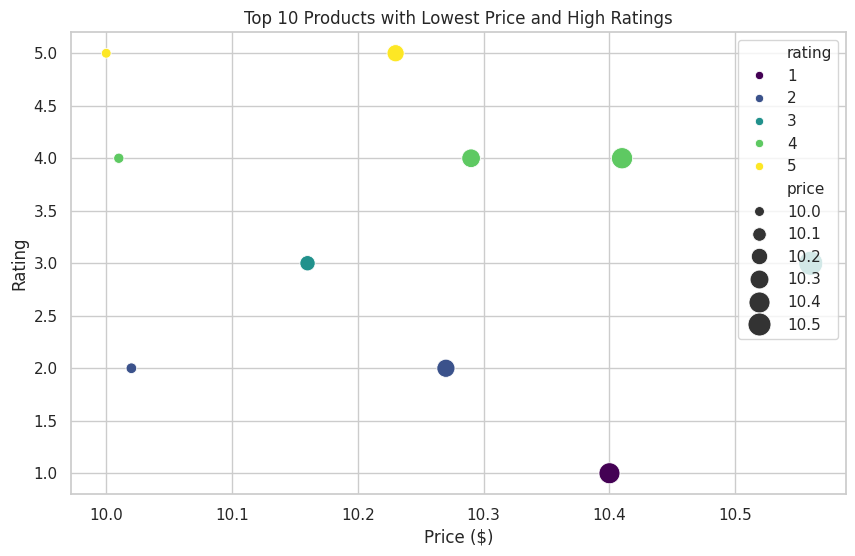

In [ ]:
low_price_high_rating = df[(df['price'] > 0) & (df['rating'] > 0)]

low_price_high_rating = low_price_high_rating.sort_values(by=['price', 'rating'], ascending=[True, False])

print("Top 10 Products with Lowest Price and High Ratings:")
print(low_price_high_rating[['product_id', 'title', 'price', 'rating']].head(10))

plt.figure(figsize=(10, 6))
sns.scatterplot(data=low_price_high_rating.head(10), x='price', y='rating', hue='rating', palette='viridis', size='price', sizes=(50, 300))
plt.title('Top 10 Products with Lowest Price and High Ratings')
plt.xlabel('Price ($)')
plt.ylabel('Rating')
plt.legend()
plt.show()

Distribution of ratings across different price ranges

<ipython-input-86-4123d1f1031a>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_rating_distribution = df.groupby(price_bins)['rating'].mean().reset_index()
<ipython-input-86-4123d1f1031a>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=price_rating_distribution, x='price', y='rating', palette='coolwarm')


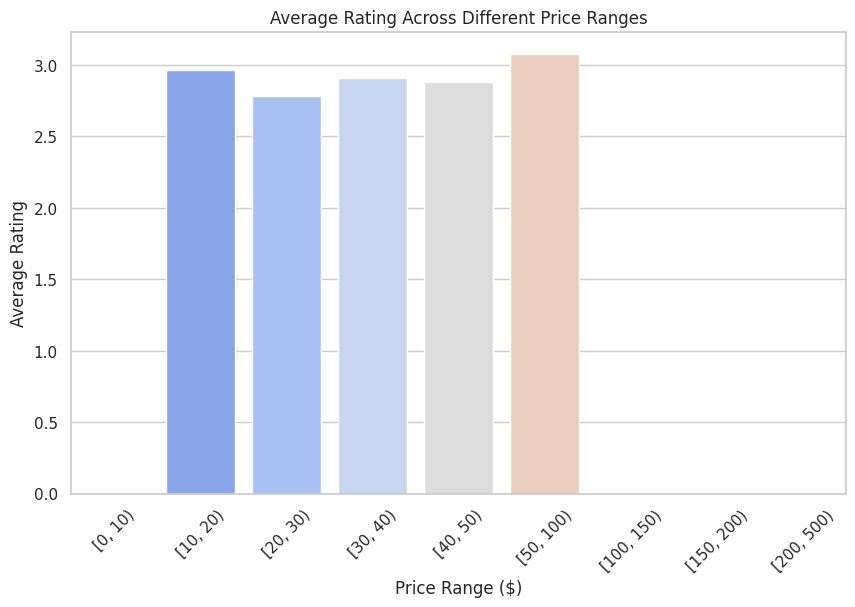

In [ ]:
price_bins = pd.cut(df['price'], bins=[0, 10, 20, 30, 40, 50, 100, 150, 200, 500], right=False)

price_rating_distribution = df.groupby(price_bins)['rating'].mean().reset_index()


plt.figure(figsize=(10, 6))
sns.barplot(data=price_rating_distribution, x='price', y='rating', palette='coolwarm')
plt.title('Average Rating Across Different Price Ranges')
plt.xlabel('Price Range ($)')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.show()